In [6]:
!pip install -q tree-sitter networkx chromadb google-generativeai matplotlib javalang pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.8 MB/s eta 

In [12]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

In [13]:
from google import genai

client = genai.Client()

response = client.models.generate_content(
    model="gemini-2.5-flash", contents="Explain how AI works in a few words"
)
print(response.text)

AI learns from data to recognize patterns and make decisions.


In [14]:
from google import genai


result = client.models.embed_content(
        model="gemini-embedding-001",
        contents="What is the meaning of life?")

print(result.embeddings)

[ContentEmbedding(
  values=[
    -0.022374554,
    -0.004560777,
    0.013309286,
    -0.0545072,
    -0.02090443,
    <... 3067 more items ...>,
  ]
)]


In [22]:
"""
Java -> AST (javalang) -> Graph (NetworkX) -> Embeddings (Google Gemini) -> ChromaDB

Usage:
1. Set GEMINI_API_KEY env var before running:
   export GEMINI_API_KEY="your_key_here"

2. Run the script. Example usage at the bottom shows parsing a folder or a single snippet.
"""

import os
import glob
import javalang
import networkx as nx
import chromadb
import google.generativeai as genai
from typing import List, Dict, Any, Tuple

genai.configure(api_key=userdata.get("GOOGLE_API_KEY"))

EMBED_MODEL = "gemini-embedding-001"  # adjust if necessary

def embed_with_gemini(text: str) -> List[float]:
    """Return embedding vector (list of floats) for given text using Gemini embeddings."""
    resp = genai.embed_content(model=EMBED_MODEL, content=text)
    # response format may vary; adapt if field names differ
    return resp["embedding"]

# ------------------------------
# ChromaDB client & collection
# ------------------------------
chroma_client = chromadb.Client()
COLLECTION_NAME = "java_code_graph_04"
collection = chroma_client.get_or_create_collection(COLLECTION_NAME)

# ------------------------------
# Java parsing with javalang
# ------------------------------
def parse_java_source(source: str) -> Dict[str, Any]:
    """
    Parse Java source with javalang and extract classes, methods, imports, and invocations.
    Returns a dict containing lists of elements.
    """
    tree = javalang.parse.parse(source)
    elements = {
        "classes": [],
        "methods": [],
        "imports": [],
        "method_calls": []  # tuples (caller_name, call_name)
    }

    # imports
    if hasattr(tree, "imports"):
        for imp in tree.imports:
            elements["imports"].append((".".join(imp.path) if isinstance(imp.path, (list, tuple)) else imp.path))

    # classes and methods
    for path, node in tree.filter(javalang.tree.TypeDeclaration):
        # node can be ClassDeclaration, InterfaceDeclaration, etc.
        if isinstance(node, javalang.tree.ClassDeclaration) or isinstance(node, javalang.tree.InterfaceDeclaration):
            cls_name = node.name
            cls_code = extract_node_source(source, node)
            elements["classes"].append({"name": cls_name, "code": cls_code, "node": node})

            # methods inside class
            for method in node.methods:
                method_name = method.name
                method_code = extract_node_source(source, method)
                full_method_id = f"{cls_name}.{method_name}"
                elements["methods"].append({
                    "class": cls_name,
                    "name": method_name,
                    "id": full_method_id,
                    "code": method_code,
                    "node": method
                })

    # method invocations (method calls) - find all MethodInvocation nodes
    for path, node in tree.filter(javalang.tree.MethodInvocation):
        # try to find the enclosing method or class (caller)
        caller = find_enclosing_method_or_class(path)
        call_name = node.member
        elements["method_calls"].append({"caller": caller, "call": call_name, "qualifier": node.qualifier if hasattr(node, "qualifier") else None, "node": node})

    return elements

def extract_node_source(source: str, node) -> str:
    """Helper: return source text for an AST node using node.position ranges."""
    # javalang nodes often have `position` (line, col) and may not carry end positions.
    # Here we do a simple heuristic: return the whole declaration by printing the node
    # (javalang nodes nicely stringify), or fallback to full source.
    try:
        return str(node)
    except Exception:
        return source

def find_enclosing_method_or_class(path) -> str:
    """
    Given a path (list of ancestor nodes from javalang.filter), find the nearest MethodDeclaration or ClassDeclaration name.
    path is a list of (ancestor_path, ancestor_node) tuples in javalang.filter output. We will inspect nodes in reverse.
    """
    # The `path` we get from tree.filter is a tuple (path_list, node). We expect path_list to be list of ancestors.
    # If path is a tuple-like: (ancestors, node) then ancestors is first element.
    try:
        ancestors, _ = path
    except Exception:
        # if not in that form, best-effort: return None
        return None
    for anc in reversed(ancestors):
        if isinstance(anc, javalang.tree.MethodDeclaration):
            return anc.name
        if isinstance(anc, javalang.tree.ClassDeclaration):
            return anc.name
    return None

# ------------------------------
# Graph construction (NetworkX)
# ------------------------------
def build_graph_from_elements(elements: Dict[str, Any]) -> nx.DiGraph:
    """
    Build a directed graph where:
      - class nodes connect to their methods with edge 'contains'
      - method -> method edges for invocations with edge 'calls'
      - import edges: file -> import (optional)
    Node attributes include 'type' and 'code'
    """
    G = nx.DiGraph()

    # Add classes
    for cls in elements.get("classes", []):
        name = cls["name"]
        G.add_node(name, type="class", code=cls.get("code", ""))

    # Add methods and class->method edges
    for m in elements.get("methods", []):
        mid = m["id"]
        G.add_node(mid, type="method", code=m.get("code", ""), class_name=m.get("class"))
        # link class -> method
        cls_name = m.get("class")
        if cls_name:
            G.add_edge(cls_name, mid, relation="contains")

    # Add call edges
    for call in elements.get("method_calls", []):
        caller = call.get("caller")
        callee_name = call.get("call")
        qualifier = call.get("qualifier")
        # callee may be unqualified; find candidate nodes with method name equals callee_name
        if callee_name:
            # try to map to fully qualified method id if available
            candidates = [n for n in G.nodes if G.nodes[n].get("type") == "method" and n.endswith(f".{callee_name}")]
            # prefer same class if caller exists
            chosen = None
            if caller:
                # if caller is method in graph, get its class and choose candidate in same class
                # find caller node in graph (could be method name alone or class)
                caller_nodes = [n for n in G.nodes if n.endswith(f".{caller}") or n == caller]
                caller_class = None
                if caller_nodes:
                    # take first caller node; if it's method, get class_name attribute
                    cn = caller_nodes[0]
                    if G.nodes[cn].get("type") == "method":
                        caller_class = G.nodes[cn].get("class_name")
                    elif G.nodes[cn].get("type") == "class":
                        caller_class = G.nodes[cn].get("class")
                # find candidate with same class
                for c in candidates:
                    if caller_class and G.nodes[c].get("class_name") == caller_class:
                        chosen = c
                        break
            if not chosen and candidates:
                chosen = candidates[0]
            if chosen:
                # add edge from caller node (if exists) else from caller string node to chosen
                # find actual caller node id in graph; prefer method id equal to "caller" or containing it
                caller_node = None
                possible = [n for n in G.nodes if n.endswith(f".{caller}")] if caller else []
                if possible:
                    caller_node = possible[0]
                else:
                    # fallback: use caller string (add ephemeral node)
                    caller_node = caller or f"caller::{caller}"
                    if caller_node not in G:
                        G.add_node(caller_node, type="unknown", code="")
                G.add_edge(caller_node, chosen, relation="calls")
            else:
                # optionally add a node for callee_name as an unresolved function
                unresolved = f"unresolved::{callee_name}"
                if unresolved not in G:
                    G.add_node(unresolved, type="unresolved", code="")
                caller_node = caller or f"caller::{caller}"
                if caller_node not in G:
                    G.add_node(caller_node, type="unknown", code="")
                G.add_edge(caller_node, unresolved, relation="calls")

    return G

# ------------------------------
# Store nodes in ChromaDB with Gemini embeddings
# ------------------------------
def store_graph_nodes_in_chroma(G: nx.DiGraph, namespace: str = None):
    """
    For each node in the graph, generate embedding for node code + small metadata text and store it to ChromaDB.
    Use node id as the Chroma id to make retrieval easy.
    """
    # optional namespace to separate datasets
    for node, data in G.nodes(data=True):
        node_type = data.get("type", "unknown")
        code = data.get("code", "")
        class_name = data.get("class_name", "")
        # Build a document text that is semantically useful
        document_text = f"Type: {node_type}\nID: {node}\nClass: {class_name}\nCode:\n{code}"
        try:
            embedding = embed_with_gemini(document_text)
        except Exception as e:
            print(f"Embedding failed for node {node}: {e}")
            embedding = []

        # Prepare metadata
        metadata = {
            "node": str(node),
            "type": node_type,
            "class": class_name
        }
        # Chroma expects 1:1 lists for add
        try:
            collection.add(
                ids=[str(node)],
                documents=[document_text],
                embeddings=[embedding] if embedding else None,
                metadatas=[metadata]
            )
        except Exception as e:
            # Some Chroma clients require embeddings present; handle accordingly
            # Fallback: add without embeddings (Chroma may compute them if a client-side embedding function is configured)
            print(f"Chroma add error for node {node}: {e}")
            try:
                collection.add(
                    ids=[str(node)],
                    documents=[document_text],
                    metadatas=[metadata]
                )
            except Exception as e2:
                print(f"Failed fallback add for node {node}: {e2}")

    print("Stored graph nodes into ChromaDB collection:", COLLECTION_NAME)

# ------------------------------
# Querying Chroma (semantic search)
# ------------------------------
def semantic_search(query: str, top_k: int = 5) -> List[Dict[str, Any]]:
    """Search the collection by embedding the query and asking Chroma for nearest docs."""
    q_emb = embed_with_gemini(query)
    results = collection.query(query_embeddings=[q_emb], n_results=top_k)
    # Chroma returns results in a dict; adapt to common layout
    matches = []
    # results structure may vary by client; try to read common fields
    docs_list = results.get("documents") or results.get("documents", [])
    metadatas_list = results.get("metadatas") or results.get("metadatas", [])
    ids_list = results.get("ids") or results.get("ids", [])
    # fallback if results nested
    if isinstance(docs_list, list) and docs_list and isinstance(docs_list[0], list):
        docs = docs_list[0]
    else:
        docs = docs_list
    if isinstance(metadatas_list, list) and metadatas_list and isinstance(metadatas_list[0], list):
        metadatas = metadatas_list[0]
    else:
        metadatas = metadatas_list
    if isinstance(ids_list, list) and ids_list and isinstance(ids_list[0], list):
        ids = ids_list[0]
    else:
        ids = ids_list

    for i in range(min(top_k, len(docs))):
        matches.append({
            "id": ids[i] if i < len(ids) else None,
            "document": docs[i] if i < len(docs) else None,
            "metadata": metadatas[i] if i < len(metadatas) else None
        })
    return matches

# ------------------------------
# Helper: recursively parse Java files in a directory
# ------------------------------
def parse_java_project_folder(root_folder: str) -> Tuple[nx.DiGraph, List[Dict[str, Any]]]:
    """
    Walks root_folder recursively, parse all .java files, build a combined graph and return it.
    """
    all_elements = {"classes": [], "methods": [], "imports": [], "method_calls": []}
    for path in glob.glob(os.path.join(root_folder, "**", "*.java"), recursive=True):
        try:
            with open(path, "r", encoding="utf-8") as f:
                src = f.read()
            elems = parse_java_source(src)
            # attach file info to each element for clarity
            for c in elems.get("classes", []):
                c["file"] = path
            for m in elems.get("methods", []):
                m["file"] = path
            for mc in elems.get("method_calls", []):
                mc["file"] = path
            # accumulate
            all_elements["classes"].extend(elems.get("classes", []))
            all_elements["methods"].extend(elems.get("methods", []))
            all_elements["imports"].extend(elems.get("imports", []))
            all_elements["method_calls"].extend(elems.get("method_calls", []))
        except Exception as e:
            print(f"Failed to parse {path}: {e}")

    G = build_graph_from_elements(all_elements)
    return G, all_elements

def semantic_graph_search(query, G, collection, depth=2, top_k=3):
    """
    query: user query
    G: NetworkX Java code graph
    collection: ChromaDB or vector store
    depth: how many graph hops to expand
    top_k: top results from semantic search
    """
    # 1️⃣ Get query embedding
    query_emb = embed_with_gemini(query)

    # 2️⃣ Perform initial vector search
    results = collection.query(query_embeddings=[query_emb], n_results=top_k)
    print (len(results))
    initial_nodes = [r for r in results["ids"][0]]  # get node ids (method/class names)

    # 3️⃣ Graph expansion
    expanded_nodes = set(initial_nodes)
    for node in initial_nodes:
        if node in G:
            for i in range(depth):
                neighbors = list(G.successors(node)) + list(G.predecessors(node))
                expanded_nodes.update(neighbors)
                # Go deeper recursively if depth > 1
                for n2 in list(neighbors):
                    neighbors2 = list(G.successors(n2)) + list(G.predecessors(n2))
                    expanded_nodes.update(neighbors2)

    # 4️⃣ Retrieve documents for expanded nodes from Chroma
    expanded_results = collection.get(where={"id": {"$in": list(expanded_nodes)}})

    # 5️⃣ (Optional) Re-rank by cosine similarity
    docs = expanded_results["documents"]
    metas = expanded_results["metadatas"]
    ids = expanded_results["ids"]

    # 6️⃣ Return enriched result
    enriched = [
        {"id": i, "document": d, "metadata": m}
        for i, d, m in zip(ids, docs, metas)
    ]
    return enriched

# ------------------------------
# Example usage
# ------------------------------
if __name__ == "__main__":
    # Example: parse a single Java snippet
    sample_code = """
    package com.example;

    import java.util.List;

    public class Calculator {
        public int add(int a, int b) { return a + b; }
        public int multiply(int a, int b) { return a * b; }

        public int computeSumList(List<Integer> xs) {
            int s = 0;
            for (int x : xs) {
                s = add(s, x);
            }
            return s;
        }
    }
    """

    #print("Parsing sample snippet with javalang...")
    #elems = parse_java_source(sample_code)
    #G = build_graph_from_elements(elems)
    # Example: parse an entire project folder (uncomment and set path)

    project_folder = "/content/ejb/ejb/src/java/com"
    G_proj, elems_proj = parse_java_project_folder(project_folder)
    store_graph_nodes_in_chroma(G_proj)
    # print("Done for project.")
    print("Graph nodes:", list(G_proj.nodes(data=True)))
    print("Graph edges:", list(G_proj.edges(data=True)))

    # Store nodes in ChromaDB using Gemini embeddings
    print("Storing nodes in ChromaDB (this will call Gemini embedding API)...")
    store_graph_nodes_in_chroma(G_proj)

    # Semantic search
    print("Semantic search for 'method that adds two numbers' ...")
    results = semantic_search("method that adds two numbers", top_k=3)
    for r in results:
        print(">>> ID:", r["id"])
        print(r["document"])
        print("metadata:", r["metadata"])
        print("---")



    print("methods in the customer class' ...")
    results = semantic_graph_search(
        "method that adds two numbers",
        G=G_proj,
        collection=collection,
        depth=3,
        top_k=2
    )

    for r in results:
        print(">>> ID:", r["id"])
        print(r["document"])
        print("metadata:", r["metadata"])
        print("---")


Stored graph nodes into ChromaDB collection: java_code_graph_04
Graph nodes: []
Graph edges: []
Storing nodes in ChromaDB (this will call Gemini embedding API)...
Stored graph nodes into ChromaDB collection: java_code_graph_04
Semantic search for 'method that adds two numbers' ...
methods in the customer class' ...
8


ValueError: Expected where operand value to be a non-empty list, and all values to be of the same type got [] in get.

In [30]:
import matplotlib.pyplot as plt

def visualize_graph(G: nx.DiGraph, title: str = "Java Code Graph"):
    """
    Visualize the Java code graph (class-method-call relations)
    using NetworkX and Matplotlib.
    """
    plt.figure(figsize=(10, 7))

    # layout: spring_layout spreads nodes naturally
    pos = nx.spring_layout(G, seed=42, k=0.5)

    # separate nodes by type
    class_nodes = [n for n, d in G.nodes(data=True) if d.get("type") == "class"]
    method_nodes = [n for n, d in G.nodes(data=True) if d.get("type") == "method"]
    unresolved_nodes = [n for n, d in G.nodes(data=True) if d.get("type") == "unresolved"]

    # draw edges first
    nx.draw_networkx_edges(G, pos, alpha=0.4, arrows=True, edge_color="gray")

    # draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=class_nodes, node_color="skyblue", node_size=1000, label="Class")
    nx.draw_networkx_nodes(G, pos, nodelist=method_nodes, node_color="lightgreen", node_size=800, label="Method")
    nx.draw_networkx_nodes(G, pos, nodelist=unresolved_nodes, node_color="lightcoral", node_size=700, label="Unresolved")

    # labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    # legend and title
    plt.legend(scatterpoints=1, loc="upper left")
    plt.title(title)
    plt.axis("off")
    plt.show()


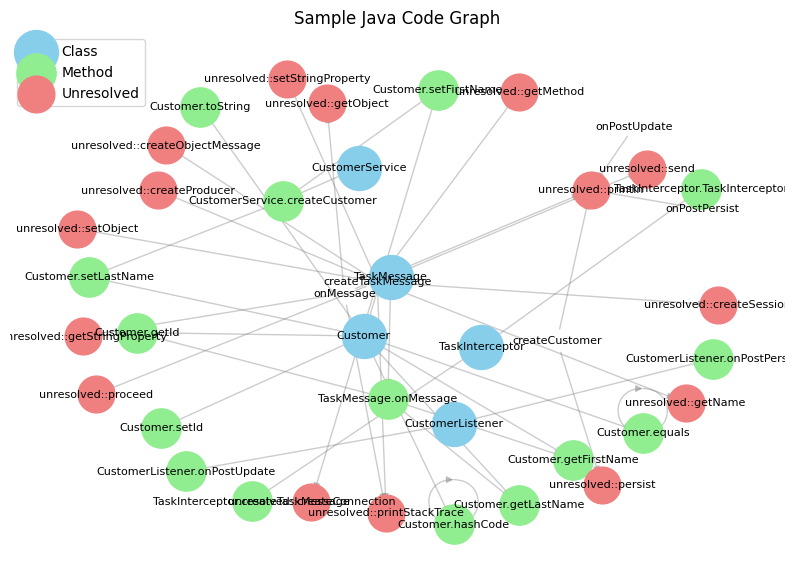

In [31]:
# Build graph from parsed Java code
G = build_graph_from_elements(elems_proj)

# Visualize it
visualize_graph(G, title="Sample Java Code Graph")


In [34]:
from pyvis.network import Network

def visualize_graph_interactive(G: nx.DiGraph, output_html="java_code_graph.html"):
    """
    Create an interactive, draggable HTML graph visualization using PyVis (Vis.js).
    """
    net = Network(height="750px", width="100%", directed=True, notebook=True)
    net.force_atlas_2based()  # smooth layout

    # map node types to colors
    color_map = {
        "class": "#68a7f7",       # blue
        "method": "#7ddf7d",      # green
        "unresolved": "#f27b7b",  # red
        "unknown": "#cccccc"
    }

    # add nodes
    for node, data in G.nodes(data=True):
        node_type = data.get("type", "unknown")
        color = color_map.get(node_type, "#ccc")
        label = node
        title = f"<b>{node}</b><br>Type: {node_type}<br><pre>{data.get('code', '')[:300]}</pre>"
        net.add_node(node, label=label, title=title, color=color)

    # add edges
    for src, dst, edata in G.edges(data=True):
        rel = edata.get("relation", "")
        color = "#888"
        if rel == "contains":
            color = "#0074D9"
        elif rel == "calls":
            color = "#FF4136"
        net.add_edge(src, dst, title=rel, color=color, arrows="to")

    # generate interactive HTML
    net.show(output_html)
    print(f"✅ Interactive graph saved to: {output_html}")


In [28]:
visualize_graph_interactive(G_proj)


java_code_graph.html
✅ Interactive graph saved to: java_code_graph.html


In [25]:
!git clone https://github.com/wbabachan/ejb.git

Cloning into 'ejb'...
remote: Enumerating objects: 58, done.
remote: Total 58 (delta 0), reused 0 (delta 0), pack-reused 58 (from 1)
Receiving objects: 100% (58/58), 58.28 KiB | 6.47 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [3]:
!pip install tree-sitter tree-sitter-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.4/635.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 4.9 MB/s eta 0:00:00


In [4]:
import tree_sitter_python as tspython
from tree_sitter import Language, Parser

PY_LANGUAGE = Language(tspython.language())
parser = Parser(PY_LANGUAGE)

src = bytes(
    """
def foo():
    if bar:
        baz()
""",
    "utf8",
)

def read_callable_byte_offset(byte_offset, point):
    return src[byte_offset : byte_offset + 1]


tree = parser.parse(read_callable_byte_offset, encoding="utf8")

In [2]:
!pip install -q tree-sitter-java

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.7 MB/s eta 0:00:00


In [5]:
from tree_sitter import Language, Parser
import tree_sitter_java as tsjava

# Load the Java language
JAVA_LANGUAGE = Language(tsjava.language())
parser = Parser(JAVA_LANGUAGE)

# Sample Java code
java_code = """
public class HelloWorld {
    public static void main(String[] args) {
        System.out.println("Hello, world!");
    }
}
"""

# Parse the Java code
tree = parser.parse(bytes(java_code, "utf8"))

# Get the root node of the AST
root_node = tree.root_node

# Print the root node and its type
print(f"Root node: {root_node}")
print(f"Root node type: {root_node.type}")

# You can now traverse the tree to explore the code structure.
# For example, let's find the class declaration:
class_declaration = root_node.child_by_field_name("declaration")
if class_declaration:
    print(f"\nClass declaration node: {class_declaration}")
    print(f"Class name: {class_declaration.child_by_field_name('name').text.decode()}")

Root node: (program (class_declaration (modifiers) name: (identifier) body: (class_body (method_declaration (modifiers) type: (void_type) name: (identifier) parameters: (formal_parameters (formal_parameter type: (array_type element: (type_identifier) dimensions: (dimensions)) name: (identifier))) body: (block (expression_statement (method_invocation object: (field_access object: (identifier) field: (identifier)) name: (identifier) arguments: (argument_list (string_literal (string_fragment))))))))))
Root node type: program


In [10]:
from typing import Dict, Any, List, Optional
from tree_sitter import Language, Parser, Node
import tree_sitter_java as tsjava


def init_parser() -> Parser:
    """Initialize tree-sitter parser for Java."""
    JAVA_LANGUAGE = Language(tsjava.language())
    parser = Parser(JAVA_LANGUAGE)
    return parser


def parse_java_source(source: str) -> Dict[str, Any]:
    """
    Parse Java source with tree-sitter and extract classes, methods, imports, and invocations.
    Returns a dict containing lists of elements.
    """
    parser = init_parser()
    tree = parser.parse(bytes(source, "utf8"))
    root_node = tree.root_node

    elements = {
        "classes": [],
        "methods": [],
        "imports": [],
        "method_calls": []
    }

    # Extract imports
    extract_imports(root_node, source, elements)

    # Extract classes and their methods
    extract_classes_and_methods(root_node, source, elements)

    # Extract method invocations
    extract_method_calls(root_node, source, elements)

    return elements


def extract_imports(node: Node, source: str, elements: Dict[str, Any]) -> None:
    """Extract import statements from the AST."""
    query_string = """
    (import_declaration) @import
    """

    for child in node.children:
        if child.type == "import_declaration":
            import_text = get_node_text(child, source)
            # Extract the import path (remove 'import' keyword and semicolon)
            import_path = import_text.replace("import", "").replace(";", "").strip()
            if import_path.startswith("static "):
                import_path = import_path.replace("static ", "").strip()
            elements["imports"].append(import_path)

        # Recursively check children
        extract_imports(child, source, elements)


def extract_classes_and_methods(node: Node, source: str, elements: Dict[str, Any]) -> None:
    """Extract class and interface declarations along with their methods."""
    if node.type in ["class_declaration", "interface_declaration"]:
        cls_name = None

        # Find class/interface name
        for child in node.children:
            if child.type == "identifier":
                cls_name = get_node_text(child, source)
                break

        if cls_name:
            cls_code = get_node_text(node, source)
            elements["classes"].append({
                "name": cls_name,
                "code": cls_code,
                "node": node
            })

            # Extract methods from this class/interface
            extract_methods_from_class(node, cls_name, source, elements)

    # Recursively process children
    for child in node.children:
        extract_classes_and_methods(child, source, elements)


def extract_methods_from_class(class_node: Node, cls_name: str, source: str, elements: Dict[str, Any]) -> None:
    """Extract method declarations from a class or interface."""
    for child in class_node.children:
        if child.type == "class_body" or child.type == "interface_body":
            for member in child.children:
                if member.type == "method_declaration":
                    method_name = None

                    # Find method name
                    for mchild in member.children:
                        if mchild.type == "identifier":
                            method_name = get_node_text(mchild, source)
                            break

                    if method_name:
                        method_code = get_node_text(member, source)
                        full_method_id = f"{cls_name}.{method_name}"
                        elements["methods"].append({
                            "class": cls_name,
                            "name": method_name,
                            "id": full_method_id,
                            "code": method_code,
                            "node": member
                        })


def extract_method_calls(node: Node, source: str, elements: Dict[str, Any]) -> None:
    """Extract method invocations (method calls) from the AST."""
    if node.type == "method_invocation":
        # Find the method name and qualifier
        method_name = None
        qualifier = None

        for child in node.children:
            if child.type == "identifier":
                method_name = get_node_text(child, source)
            elif child.type == "field_access":
                # Handle chained calls like obj.method()
                qualifier = get_node_text(child, source)
            elif child.type in ["this", "super"]:
                qualifier = child.type

        if method_name:
            # Find enclosing method or class
            caller = find_enclosing_method_or_class(node)

            elements["method_calls"].append({
                "caller": caller,
                "call": method_name,
                "qualifier": qualifier,
                "node": node
            })

    # Recursively process children
    for child in node.children:
        extract_method_calls(child, source, elements)


def get_node_text(node: Node, source: str) -> str:
    """Extract the source text for a given node."""
    return source[node.start_byte:node.end_byte]


def find_enclosing_method_or_class(node: Node) -> Optional[str]:
    """
    Find the name of the enclosing method or class for a given node.
    Traverses up the tree to find the nearest method or class declaration.
    """
    current = node.parent

    while current is not None:
        if current.type == "method_declaration":
            # Find method name
            for child in current.children:
                if child.type == "identifier":
                    return child.text.decode("utf8") if isinstance(child.text, bytes) else child.text

        elif current.type in ["class_declaration", "interface_declaration"]:
            # Find class/interface name
            for child in current.children:
                if child.type == "identifier":
                    return child.text.decode("utf8") if isinstance(child.text, bytes) else child.text

        current = current.parent

    return None


# Example usage
if __name__ == "__main__":
    java_code = """
    import java.util.List;
    import java.util.ArrayList;

    public class Example {
        private String name;

        public void greet() {
            System.out.println("Hello");
            helper();
        }

        private void helper() {
            name.toString();
        }
    }
    """

    result = parse_java_source(java_code)

    print("Imports:", result["imports"])
    print("\nClasses:")
    for cls in result["classes"]:
        print(f"  - {cls['name']}")

    print("\nMethods:")
    for method in result["methods"]:
        print(f"  - {method['id']}")

    print("\nMethod Calls:")
    for call in result["method_calls"]:
        print(f"  - {call['caller']} calls {call['call']}")

Imports: ['java.util.List', 'java.util.ArrayList']

Classes:
  - Example

Methods:
  - Example.greet
  - Example.helper

Method Calls:
  - greet calls println
  - greet calls helper
  - helper calls toString


In [32]:
"""
Java -> AST (tree-sitter) -> Graph (NetworkX) -> Embeddings (Google Gemini) -> ChromaDB

Usage:
1. Set GEMINI_API_KEY env var before running:
   export GEMINI_API_KEY="your_key_here"

2. Install dependencies:
   pip install tree-sitter tree-sitter-java networkx chromadb google-generativeai

3. Run the script. Example usage at the bottom shows parsing a folder or a single snippet.
"""

import os
import glob
import networkx as nx
import chromadb
import google.generativeai as genai
from typing import List, Dict, Any, Tuple, Optional
from tree_sitter import Language, Parser, Node
import tree_sitter_java as tsjava

# Configure Gemini API
# genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))

EMBED_MODEL = "gemini-embedding-001"  # adjust if necessary

def embed_with_gemini(text: str) -> List[float]:
    """Return embedding vector (list of floats) for given text using Gemini embeddings."""
    resp = genai.embed_content(model=EMBED_MODEL, content=text)
    return resp["embedding"]

# ------------------------------
# ChromaDB client & collection
# ------------------------------
chroma_client = chromadb.Client()
COLLECTION_NAME = "java_code_graph_treesitter_01"
collection = chroma_client.get_or_create_collection(COLLECTION_NAME)

# ------------------------------
# Tree-sitter parser initialization
# ------------------------------
def init_parser() -> Parser:
    """Initialize tree-sitter parser for Java."""
    JAVA_LANGUAGE = Language(tsjava.language())
    parser = Parser(JAVA_LANGUAGE)
    return parser

# ------------------------------
# Java parsing with tree-sitter
# ------------------------------
def parse_java_source(source: str) -> Dict[str, Any]:
    """
    Parse Java source with tree-sitter and extract classes, methods, imports, and invocations.
    Returns a dict containing lists of elements.
    """
    parser = init_parser()
    tree = parser.parse(bytes(source, "utf8"))
    root_node = tree.root_node

    elements = {
        "classes": [],
        "methods": [],
        "imports": [],
        "method_calls": []
    }

    # Extract imports
    extract_imports(root_node, source, elements)

    # Extract classes and their methods
    extract_classes_and_methods(root_node, source, elements)

    # Extract method invocations
    extract_method_calls(root_node, source, elements)

    return elements


def extract_imports(node: Node, source: str, elements: Dict[str, Any]) -> None:
    """Extract import statements from the AST."""
    for child in node.children:
        if child.type == "import_declaration":
            import_text = get_node_text(child, source)
            # Extract the import path (remove 'import' keyword and semicolon)
            import_path = import_text.replace("import", "").replace(";", "").strip()
            if import_path.startswith("static "):
                import_path = import_path.replace("static ", "").strip()
            elements["imports"].append(import_path)

        # Recursively check children
        extract_imports(child, source, elements)


def extract_classes_and_methods(node: Node, source: str, elements: Dict[str, Any]) -> None:
    """Extract class and interface declarations along with their methods."""
    if node.type in ["class_declaration", "interface_declaration", "enum_declaration"]:
        cls_name = None

        # Find class/interface name
        for child in node.children:
            if child.type == "identifier":
                cls_name = get_node_text(child, source)
                break

        if cls_name:
            cls_code = get_node_text(node, source)
            elements["classes"].append({
                "name": cls_name,
                "code": cls_code,
                "node": node
            })

            # Extract methods from this class/interface
            extract_methods_from_class(node, cls_name, source, elements)

    # Recursively process children
    for child in node.children:
        extract_classes_and_methods(child, source, elements)


def extract_methods_from_class(class_node: Node, cls_name: str, source: str, elements: Dict[str, Any]) -> None:
    """Extract method declarations from a class or interface."""
    for child in class_node.children:
        if child.type in ["class_body", "interface_body", "enum_body"]:
            for member in child.children:
                if member.type == "method_declaration":
                    method_name = None

                    # Find method name
                    for mchild in member.children:
                        if mchild.type == "identifier":
                            method_name = get_node_text(mchild, source)
                            break

                    if method_name:
                        method_code = get_node_text(member, source)
                        full_method_id = f"{cls_name}.{method_name}"
                        elements["methods"].append({
                            "class": cls_name,
                            "name": method_name,
                            "id": full_method_id,
                            "code": method_code,
                            "node": member
                        })
                elif member.type == "constructor_declaration":
                    # Handle constructors
                    method_name = None
                    for mchild in member.children:
                        if mchild.type == "identifier":
                            method_name = get_node_text(mchild, source)
                            break

                    if method_name:
                        method_code = get_node_text(member, source)
                        full_method_id = f"{cls_name}.{method_name}"
                        elements["methods"].append({
                            "class": cls_name,
                            "name": method_name,
                            "id": full_method_id,
                            "code": method_code,
                            "node": member
                        })


def extract_method_calls(node: Node, source: str, elements: Dict[str, Any]) -> None:
    """Extract method invocations (method calls) from the AST."""
    if node.type == "method_invocation":
        # Find the method name and qualifier
        method_name = None
        qualifier = None

        for child in node.children:
            if child.type == "identifier":
                method_name = get_node_text(child, source)
            elif child.type == "field_access":
                # Handle chained calls like obj.method()
                qualifier = get_node_text(child, source)
            elif child.type in ["this", "super"]:
                qualifier = child.type

        # Alternative: method_name might be nested in other structures
        if not method_name:
            # Check for direct identifier children
            for child in node.children:
                if child.type == "identifier":
                    method_name = get_node_text(child, source)
                    break

        if method_name:
            # Find enclosing method or class
            caller = find_enclosing_method_or_class(node, source)

            elements["method_calls"].append({
                "caller": caller,
                "call": method_name,
                "qualifier": qualifier,
                "node": node
            })

    # Recursively process children
    for child in node.children:
        extract_method_calls(child, source, elements)


def get_node_text(node: Node, source: str) -> str:
    """Extract the source text for a given node."""
    return source[node.start_byte:node.end_byte]


def find_enclosing_method_or_class(node: Node, source: str) -> Optional[str]:
    """
    Find the name of the enclosing method or class for a given node.
    Traverses up the tree to find the nearest method or class declaration.
    """
    current = node.parent

    while current is not None:
        if current.type in ["method_declaration", "constructor_declaration"]:
            # Find method name
            for child in current.children:
                if child.type == "identifier":
                    text = child.text
                    return text.decode("utf8") if isinstance(text, bytes) else text

        elif current.type in ["class_declaration", "interface_declaration", "enum_declaration"]:
            # Find class/interface name
            for child in current.children:
                if child.type == "identifier":
                    text = child.text
                    return text.decode("utf8") if isinstance(text, bytes) else text

        current = current.parent

    return None


# ------------------------------
# Graph construction (NetworkX)
# ------------------------------
def build_graph_from_elements(elements: Dict[str, Any]) -> nx.DiGraph:
    """
    Build a directed graph where:
      - class nodes connect to their methods with edge 'contains'
      - method -> method edges for invocations with edge 'calls'
      - import edges: file -> import (optional)
    Node attributes include 'type' and 'code'
    """
    G = nx.DiGraph()

    # Add classes
    for cls in elements.get("classes", []):
        name = cls["name"]
        G.add_node(name, type="class", code=cls.get("code", ""))

    # Add methods and class->method edges
    for m in elements.get("methods", []):
        mid = m["id"]
        G.add_node(mid, type="method", code=m.get("code", ""), class_name=m.get("class"))
        # link class -> method
        cls_name = m.get("class")
        if cls_name:
            G.add_edge(cls_name, mid, relation="contains")

    # Add call edges
    for call in elements.get("method_calls", []):
        caller = call.get("caller")
        callee_name = call.get("call")
        qualifier = call.get("qualifier")
        # callee may be unqualified; find candidate nodes with method name equals callee_name
        if callee_name:
            # try to map to fully qualified method id if available
            candidates = [n for n in G.nodes if G.nodes[n].get("type") == "method" and n.endswith(f".{callee_name}")]
            # prefer same class if caller exists
            chosen = None
            if caller:
                # if caller is method in graph, get its class and choose candidate in same class
                # find caller node in graph (could be method name alone or class)
                caller_nodes = [n for n in G.nodes if n.endswith(f".{caller}") or n == caller]
                caller_class = None
                if caller_nodes:
                    # take first caller node; if it's method, get class_name attribute
                    cn = caller_nodes[0]
                    if G.nodes[cn].get("type") == "method":
                        caller_class = G.nodes[cn].get("class_name")
                    elif G.nodes[cn].get("type") == "class":
                        caller_class = G.nodes[cn].get("class")
                # find candidate with same class
                for c in candidates:
                    if caller_class and G.nodes[c].get("class_name") == caller_class:
                        chosen = c
                        break
            if not chosen and candidates:
                chosen = candidates[0]
            if chosen:
                # add edge from caller node (if exists) else from caller string node to chosen
                # find actual caller node id in graph; prefer method id equal to "caller" or containing it
                caller_node = None
                possible = [n for n in G.nodes if n.endswith(f".{caller}")] if caller else []
                if possible:
                    caller_node = possible[0]
                else:
                    # fallback: use caller string (add ephemeral node)
                    caller_node = caller or f"caller::{caller}"
                    if caller_node not in G:
                        G.add_node(caller_node, type="unknown", code="")
                G.add_edge(caller_node, chosen, relation="calls")
            else:
                # optionally add a node for callee_name as an unresolved function
                unresolved = f"unresolved::{callee_name}"
                if unresolved not in G:
                    G.add_node(unresolved, type="unresolved", code="")
                caller_node = caller or f"caller::{caller}"
                if caller_node not in G:
                    G.add_node(caller_node, type="unknown", code="")
                G.add_edge(caller_node, unresolved, relation="calls")

    return G

# ------------------------------
# Store nodes in ChromaDB with Gemini embeddings
# ------------------------------
def store_graph_nodes_in_chroma(G: nx.DiGraph, namespace: str = None):
    """
    For each node in the graph, generate embedding for node code + small metadata text and store it to ChromaDB.
    Use node id as the Chroma id to make retrieval easy.
    """
    # optional namespace to separate datasets
    for node, data in G.nodes(data=True):
        node_type = data.get("type", "unknown")
        code = data.get("code", "")
        class_name = data.get("class_name", "")
        # Build a document text that is semantically useful
        document_text = f"Type: {node_type}\nID: {node}\nClass: {class_name}\nCode:\n{code}"
        try:
            embedding = embed_with_gemini(document_text)
        except Exception as e:
            print(f"Embedding failed for node {node}: {e}")
            embedding = []

        # Prepare metadata
        metadata = {
            "node": str(node),
            "type": node_type,
            "class": class_name
        }
        # Chroma expects 1:1 lists for add
        try:
            collection.add(
                ids=[str(node)],
                documents=[document_text],
                embeddings=[embedding] if embedding else None,
                metadatas=[metadata]
            )
        except Exception as e:
            # Some Chroma clients require embeddings present; handle accordingly
            # Fallback: add without embeddings (Chroma may compute them if a client-side embedding function is configured)
            print(f"Chroma add error for node {node}: {e}")
            try:
                collection.add(
                    ids=[str(node)],
                    documents=[document_text],
                    metadatas=[metadata]
                )
            except Exception as e2:
                print(f"Failed fallback add for node {node}: {e2}")

    print("Stored graph nodes into ChromaDB collection:", COLLECTION_NAME)

# ------------------------------
# Querying Chroma (semantic search)
# ------------------------------
def semantic_search(query: str, top_k: int = 5) -> List[Dict[str, Any]]:
    """Search the collection by embedding the query and asking Chroma for nearest docs."""
    q_emb = embed_with_gemini(query)
    results = collection.query(query_embeddings=[q_emb], n_results=top_k)
    # Chroma returns results in a dict; adapt to common layout
    matches = []
    # results structure may vary by client; try to read common fields
    docs_list = results.get("documents") or results.get("documents", [])
    metadatas_list = results.get("metadatas") or results.get("metadatas", [])
    ids_list = results.get("ids") or results.get("ids", [])
    # fallback if results nested
    if isinstance(docs_list, list) and docs_list and isinstance(docs_list[0], list):
        docs = docs_list[0]
    else:
        docs = docs_list
    if isinstance(metadatas_list, list) and metadatas_list and isinstance(metadatas_list[0], list):
        metadatas = metadatas_list[0]
    else:
        metadatas = metadatas_list
    if isinstance(ids_list, list) and ids_list and isinstance(ids_list[0], list):
        ids = ids_list[0]
    else:
        ids = ids_list

    for i in range(min(top_k, len(docs))):
        matches.append({
            "id": ids[i] if i < len(ids) else None,
            "document": docs[i] if i < len(docs) else None,
            "metadata": metadatas[i] if i < len(metadatas) else None
        })
    return matches

# ------------------------------
# Helper: recursively parse Java files in a directory
# ------------------------------
def parse_java_project_folder(root_folder: str) -> Tuple[nx.DiGraph, List[Dict[str, Any]]]:
    """
    Walks root_folder recursively, parse all .java files, build a combined graph and return it.
    """
    all_elements = {"classes": [], "methods": [], "imports": [], "method_calls": []}
    for path in glob.glob(os.path.join(root_folder, "**", "*.java"), recursive=True):
        try:
            with open(path, "r", encoding="utf-8") as f:
                src = f.read()
            elems = parse_java_source(src)
            # attach file info to each element for clarity
            for c in elems.get("classes", []):
                c["file"] = path
            for m in elems.get("methods", []):
                m["file"] = path
            for mc in elems.get("method_calls", []):
                mc["file"] = path
            # accumulate
            all_elements["classes"].extend(elems.get("classes", []))
            all_elements["methods"].extend(elems.get("methods", []))
            all_elements["imports"].extend(elems.get("imports", []))
            all_elements["method_calls"].extend(elems.get("method_calls", []))
        except Exception as e:
            print(f"Failed to parse {path}: {e}")

    G = build_graph_from_elements(all_elements)
    return G, all_elements

def semantic_graph_search(query, G, collection, depth=2, top_k=3):
    """
    query: user query
    G: NetworkX Java code graph
    collection: ChromaDB or vector store
    depth: how many graph hops to expand
    top_k: top results from semantic search
    """
    # 1️⃣ Get query embedding
    query_emb = embed_with_gemini(query)

    # 2️⃣ Perform initial vector search
    results = collection.query(query_embeddings=[query_emb], n_results=top_k)
    print(len(results))
    initial_nodes = [r for r in results["ids"][0]]  # get node ids (method/class names)

    # 3️⃣ Graph expansion
    expanded_nodes = set(initial_nodes)
    for node in initial_nodes:
        if node in G:
            for i in range(depth):
                neighbors = list(G.successors(node)) + list(G.predecessors(node))
                expanded_nodes.update(neighbors)
                # Go deeper recursively if depth > 1
                for n2 in list(neighbors):
                    neighbors2 = list(G.successors(n2)) + list(G.predecessors(n2))
                    expanded_nodes.update(neighbors2)

    # 4️⃣ Retrieve documents for expanded nodes from Chroma
    # expanded_results = collection.get(where={"id": {"$in": list(expanded_nodes)}})
    expanded_results = collection.get(ids=list(expanded_nodes))

    # 5️⃣ (Optional) Re-rank by cosine similarity
    docs = expanded_results["documents"]
    metas = expanded_results["metadatas"]
    ids = expanded_results["ids"]

    # 6️⃣ Return enriched result
    enriched = [
        {"id": i, "document": d, "metadata": m}
        for i, d, m in zip(ids, docs, metas)
    ]
    return enriched

# ------------------------------
# Example usage
# ------------------------------
if __name__ == "__main__":
    # Example: parse a single Java snippet
    sample_code = """
    package com.example;

    import java.util.List;

    public class Calculator {
        public int add(int a, int b) { return a + b; }
        public int multiply(int a, int b) { return a * b; }

        public int computeSumList(List<Integer> xs) {
            int s = 0;
            for (int x : xs) {
                s = add(s, x);
            }
            return s;
        }
    }
    """

    print("Parsing sample snippet with tree-sitter...")
    # elems = parse_java_source(sample_code)
    # G = build_graph_from_elements(elems)

    # Example: parse an entire project folder (uncomment and set path)
    project_folder = "/content/ejb/ejb/src/java/com"
    G_proj, elems_proj = parse_java_project_folder(project_folder)
    store_graph_nodes_in_chroma(G_proj)
    print("Done for project.")

    print("Graph nodes:", list(G_proj.nodes(data=True)))
    print("Graph edges:", list(G_proj.edges(data=True)))

    # Store nodes in ChromaDB using Gemini embeddings
    print("Storing nodes in ChromaDB (this will call Gemini embedding API)...")
    store_graph_nodes_in_chroma(G_proj)

    # Semantic search
    print("Semantic search for 'customer' ...")
    results = semantic_search("method that adds two numbers", top_k=3)
    for r in results:
        print(">>> ID:", r["id"])
        print(r["document"])
        print("metadata:", r["metadata"])
        print("---")

    print("Semantic customer...")
    results = semantic_graph_search(
        "method that adds two numbers",
        G=G_proj,
        collection=collection,
        depth=3,
        top_k=2
    )

    for r in results:
        print(">>> ID:", r["id"])
        print(r["document"])
        print("metadata:", r["metadata"])
        print("---")

Parsing sample snippet with tree-sitter...
Stored graph nodes into ChromaDB collection: java_code_graph_treesitter_01
Done for project.
Graph nodes: [('TaskMessage', {'type': 'class', 'code': '@MessageDriven(activationConfig = {\n        @ActivationConfigProperty(\n            propertyName = "destination",\n            propertyValue = "ejbQueue"\n        ),\n        @ActivationConfigProperty(\n            propertyName = "destinationType",\n            propertyValue = "javax.jms.Queue"\n        ),\n        @ActivationConfigProperty(\n            propertyName = "messageSelector",\n            propertyValue = "operation = \'createCustomer\'"\n        )\n    }\n)\npublic class TaskMessage implements MessageListener {\n    \n    @Override\n    public void onMessage(Message message) {\n        try {\n            if (message instanceof ObjectMessage) {\n                String operation = message.getStringProperty("operation");\n                Object object = ((ObjectMessage)message).getObjec

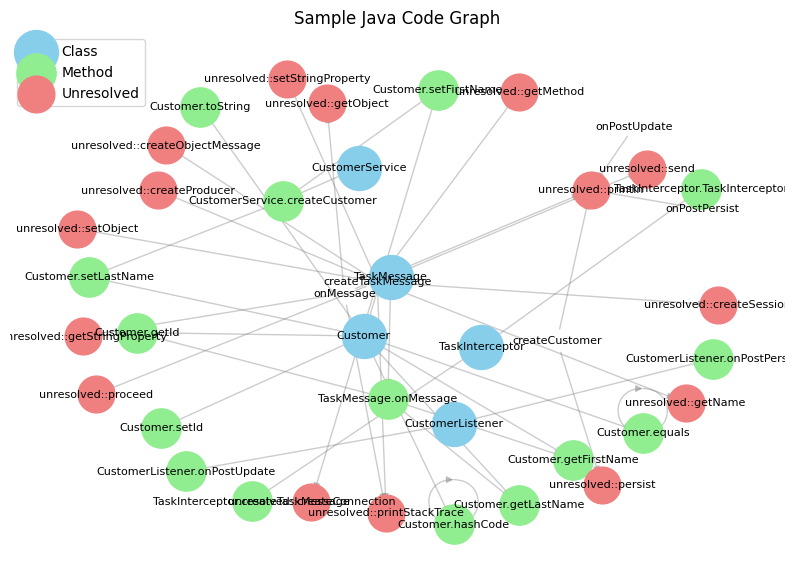

In [33]:
# Build graph from parsed Java code
# G = build_graph_from_elements(elems_proj)

# Visualize it
visualize_graph(G_proj, title="Sample Java Code Graph")